# Argon A-to-Z

This tutorial demonstrates a-to-z how to optimise Lennard Jones parameters for liquid argon, and without going into details. For details see other tutorials and wider MDMC documentation.

In [1]:
# Imports used for this tutorial
import numpy as np
import os
from MDMC.control import Control
from MDMC.MD import Atom, Dispersion, LennardJones, Simulation, Universe

Supported DL_POLY version 4.10


In [2]:
# Change the number of threads depending on the number of physical cores on your computer
# as it was tested for LAMMPS
os.environ["OMP_NUM_THREADS"] = "4"

In [3]:
# Build universe with density 0.0176 atoms per AA^-3
density = 0.0176
# This means cubic universe of side:
# 23.0668 A will contain 216 Ar atoms
# 26.911 A will contain 343 Ar atoms
# 30.7553 A will contain 512 Ar atoms
# 38.4441 A will contain 1000 Ar atoms
universe = Universe(dimensions=23.0668)
Ar = Atom('Ar', charge=0.)
# Calculating number of Ar atoms needed to obtain density
n_ar_atoms = int(density * np.product(universe.dimensions))
print(f'Number of argon atoms = {n_ar_atoms}')
universe.fill(Ar, num_struc_units=(n_ar_atoms))

Universe created with:
  Dimensions       [23.07, 23.07, 23.07]
  Force field                       None
  Number of atoms                      0

Number of argon atoms = 216


In the Jupyter cell above, a box of Argon atoms is set up. However, at this point there is no interaction forces between the argon atoms! In the cell below an appropriate (for argon) force-field interaction potential is defined.

In [4]:
Ar_dispersion = Dispersion(universe,
                           (Ar.atom_type, Ar.atom_type),
                           cutoff=8.,
                           function=LennardJones(epsilon=1.0243, sigma=3.36))

In this case the interaction potential chosen is the humble Lennard Jones (to get info see doc or type `help(LennardJones)`).

Also, a `cutoff` value is chosen (see `help(Dispersion)` for more info). A [rule of thumb for Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is to pick `cutoff=2.5*sigma`. The value for argon is recommended to be between 8 and 12 ang. `cutoff` is not a force-field parameter and therefore will not be refined. Ideally, and for any system you want to pick at value of the `cutoff` which is small while not compromising accuracy. For this system picking a value between 8 and 12 ang is found to give near identifical results.

Next (and before starting the refinement), we set up the MD engine and equilibrate the system. Note with MDMC the equilibration only needs to be done once. 

In [5]:
# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
LAMMPS output is captured by PyLammps wrapper
LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
Total wall time: 0:00:00
using multi-threaded neighbor list subroutines


Simulation created with lammps engine and settings:
  temperature  120.0



In [6]:
# Energy Minimization and equilibration
simulation.minimize(n_steps=5000)
simulation.run(n_steps=10000, equilibration=True)

OK; time to set up the actual refinement of the force-field parameters. 

First we need some data to refine against:

In [7]:
# exp_datasets is a list of dictionaries with one dictionary per experimental
# dataset
# Dataset from: van Well et al. (1985). Physical Review A, 31(5), 3391-3414
# resolution is None as the original author already accounted for instrument resolution
exp_datasets = [{'file_name':'data/Well_s_q_omega_Ar_data.xml',
                 'type':'SQw',
                 'reader':'xml_SQw',
                 'weight':1.,
                 'auto_scale':True,
                 'resolution':None}]

The number of `MD_steps` specified must be large enough to allow for successful calculation of all observables. This depends the `type` of the dataset provided and the value of the `traj_step` (specified when creating the `Simulation`). If a value for `MD_steps` is not provided, then the minimum number needed will be used automatically.

Additionally, some observables will have an upper limit on the number of MD_steps that can be used in calculating their dependent variable(s). In these cases, the number of `MD_steps` is rounded down to a multiple of this upper limit so that we only run steps that will be useful. For example, if we use 1000 `MD_steps` in calculation, but a value of 2500 is provided, then we will run 2000 steps and use this to calculate the variable twice, without wasting time performing an additional 500 steps.

In [8]:
fit_parameters = universe.parameters
fit_parameters['sigma'].constraints = [2.8,3.8]
fit_parameters['epsilon'].constraints = [0.6, 1.4]


control = Control(simulation=simulation,
                  exp_datasets=exp_datasets,
                  fit_parameters=fit_parameters,
                  minimizer_type="GPO",
                  reset_config=True,
                  MD_steps=2000, 
                  equilibration_steps=2000,
                  n_points=40)

Control created with:
- Attributes                              -
  Minimizer                             GPO
  FoM type               ChiSquaredExpError
  Number of observables                   1
  Number of parameters                    2



And finally start the refinement! Bump up `n_steps` from 3 when you are ready.

Step         FoM Change state  Pred coords     Pred FoM epsilon (#2)   sigma (#3)


   0       339.2     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.024         3.36


   1       455.9     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.035        3.532


   2       782.9     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.075        2.905


   3       882.7     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.9356        3.782


   4       464.9     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.396         3.47


   5       576.9     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.7189        2.876


   6       384.7     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.9139        3.198


   7       541.5     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.8076        3.693


   8       365.8     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.6141        3.271


   9        1206     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.174        2.812


  10       345.7     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.9896        3.336


  11         675     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.218        2.966


  12       501.3     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        0.747        3.001


  13       426.5     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.7752        3.566


  14       789.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.141        3.713


  15       398.3     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        0.665        3.619


  16       702.2     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.354        3.098


  17       452.8     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.304        3.223


  18         484     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.119        3.104


  19       356.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.8776        3.441


  20         357     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2        1.039         3.37


  21       347.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.6037        3.388


  22       373.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        339.2       0.7957        3.355


  23       337.5     Accepted [0.6010215991080279 kJ / mol, 3.4920701289835465 Ang]        337.5        0.601        3.492


  24       402.4     Accepted [0.6010215991080279 kJ / mol, 3.4920701289835465 Ang]        337.5        1.163        3.316


  25       331.8     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8       0.6004        3.455


  26       350.3     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8       0.6024        3.441


  27         356     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8       0.6001        3.522


  28       389.6     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8        0.604        3.187


  29       380.3     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8        0.949        3.383


  30       345.4     Accepted [0.6003512915646689 kJ / mol, 3.454530366084757 Ang]        331.8       0.6038         3.46


  31       327.8     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8        0.604        3.454


  32       367.2     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8        0.924        3.283


  33       351.2     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8       0.6001        3.428


  34       339.5     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8       0.6876        3.458


  35       332.9     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8       0.6031        3.472


  36       368.8     Accepted [0.6039559297023549 kJ / mol, 3.4535915891493136 Ang]        327.8       0.6826        3.472


  37       312.2     Accepted [0.6002766792234207 kJ / mol, 3.477143654077085 Ang]        312.2       0.6003        3.477


  38       497.2     Accepted [0.6002766792234207 kJ / mol, 3.477143654077085 Ang]        312.2        0.603        3.661


  39       411.3     Accepted [0.6002766792234207 kJ / mol, 3.477143654077085 Ang]        312.2        1.397        3.359

The refinement has finished. 
 
Minimum measured point is: 
(0.6002766792234207 kJ / mol, 3.477143654077085 Ang) with an FoM of 312.22314284550737. 
 
Minimum point predicted is: 
(0.6002766792234207 kJ / mol, 3.477143654077085 Ang) for an FoM of 312.22314284550737.
 
 

Automatic Scale Factors
  data/Well_s_q_omega_Ar_data.xml  0.217078


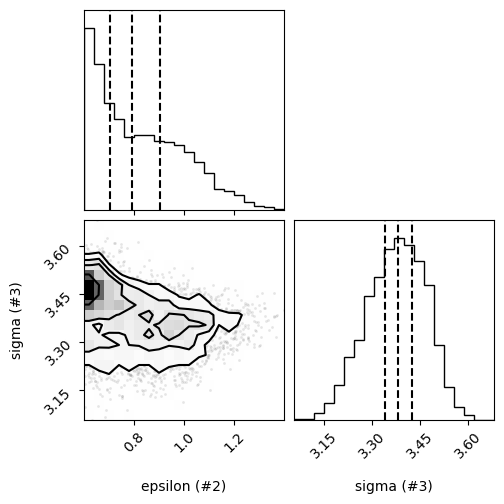

In [9]:
# Run the refinement, i.e. refine the FF parameters against the data
control.refine(n_steps=40)
control.plot_results();